In [1]:
from QuantLib import *
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
depo_maturities = [Period(6, Months), Period(12, Months)]
depo_rates = [5.25, 5.5]

# Bond rate
bond_maturities = [Period(6*i, Months) for i in range(3, 21)]
bond_rates = [5.75, 6, 6.25, 6.5, 6.75, 6.8, 7.00, 7.1, 7.15,
              7.2, 7.3, 7.35, 7.4, 7.5, 7.6, 7.6, 7.7, 7.8]

maturities = depo_maturities + bond_maturities
rates = depo_rates + bond_rates

DataFrame(zip(maturities, rates),
          columns=["Maturities", "Curve"],
          index=[""] * len(rates))

,Maturities,Curve
,6M,5.25
,1Y,5.50
,1Y6M,5.75
,2Y,6.00
,2Y6M,6.25
,3Y,6.50
,3Y6M,6.75
,4Y,6.80
,4Y6M,7.00
,5Y,7.10


In [3]:
calc_date = Date(15, 1, 2015)
Settings.instance().evaluationDate = calc_date

calendar = UnitedStates()
business_convention = Unadjusted
day_count = Thirty360()
end_of_month = True
settlement_days = 0
face_amount = 100
coupon_frequency = Period(Semiannual)
settlement_days = 0

In [4]:
depo_helpers = [DepositRateHelper(QuoteHandle(SimpleQuote(r/100.0)), m, settlement_days, calendar, 
                                   business_convention, end_of_month, day_count)
                for r, m in zip(depo_rates, depo_maturities)]

In [5]:
bond_helpers = []

for r, m in zip(bond_rates, bond_maturities):
    termination_date = calc_date + m
    schedule = Schedule(calc_date,
                        termination_date,
                        coupon_frequency, 
                        calendar,
                        business_convention,
                        business_convention,
                        DateGeneration.Backward,
                        end_of_month)
    
    
bond_helper = FixedRateBondHelper(QuoteHandle(SimpleQuote(face_amount)),
                                  settlement_days,
                                  face_amount,
                                  schedule,
                                  [r/100.0],
                                  day_count,
                                  business_convention)

bond_helpers.append(bond_helper)

In [6]:
rate_helpers = depo_helpers + bond_helpers
print(rate_helpers)

[<QuantLib.QuantLib.DepositRateHelper; proxy of <Swig Object of type 'DepositRateHelperPtr *' at 0x000001AB7C178A80> >, <QuantLib.QuantLib.DepositRateHelper; proxy of <Swig Object of type 'DepositRateHelperPtr *' at 0x000001AB7C178930> >, <QuantLib.QuantLib.FixedRateBondHelper; proxy of <Swig Object of type 'FixedRateBondHelperPtr *' at 0x000001AB7C178AE0> >]


In [7]:
def get_spot_rates(yieldcurve, day_count, calendar=UnitedStates(), months=121):
    spots = []
    tenors = []
    ref_date = yieldcurve.referenceDate()
    calc_date = ref_date
    
    for month in range(0, months):
        yrs = month / 12.0
        d = calendar.advance(ref_date, Period(month, Months))
        compounding = Compounded
        freq = Semiannual
        zero_rate = yieldcurve.zeroRate(yrs, compounding, freq)
        tenors.append(yrs)
        eq_rate = zero_rate.equivalentRate(day_count,compounding, freq, calc_date, d).rate()
        spots.append(100*eq_rate)
        
    return DataFrame(zip(tenors, spots), columns=["Maturities", "Curve"], index=[""]*len(tenors))


In [8]:
# PiecewiseLogCubicDiscount construct piece wise yield curve using LogCubic interpolation of the Discount factor

yc_logcubicdiscount = PiecewiseLogCubicDiscount(calc_date, rate_helpers, day_count)

print(yc_logcubicdiscount.referenceDate())

January 15th, 2015


In [9]:
splcd = get_spot_rates(yc_logcubicdiscount, day_count)
print(splcd)

    Maturities     Curve
      0.000000  0.000000
      0.083333  5.181714
      0.166667  5.187566
      0.250000  5.197320
      0.333333  5.210977
      0.416667  5.228536
      0.500000  5.250000
      0.583333  5.275096
      0.666667  5.302731
      0.750000  5.332088
      0.833333  5.362673
      0.916667  5.394176
      1.000000  5.426386
      1.083333  5.459148
      1.166667  5.492310
      1.250000  5.525746
      1.333333  5.559367
      1.416667  5.593101
      1.500000  5.626893
      1.583333  5.660700
      1.666667  5.694488
      1.750000  5.728228
      1.833333  5.761897
      1.916667  5.795477
      2.000000  5.828951
      2.083333  5.862307
      2.166667  5.895532
      2.250000  5.928618
      2.333333  5.961555
      2.416667  5.994337
..         ...       ...
      7.583333  7.635753
      7.666667  7.655465
      7.750000  7.674957
      7.833333  7.694229
      7.916667  7.713280
      8.000000  7.732111
      8.083333  7.750722
      8.166667  7.769112


In [12]:
# Using Linear interpolation of Zero rate

yc_linearzero = PiecewiseLinearZero(calc_date, rate_helpers, day_count)
splz = get_spot_rates(yc_linearzero, day_count)
print(splz)

    Maturities     Curve
      0.000000  0.000000
      0.083333  5.250000
      0.166667  5.250000
      0.250000  5.250000
      0.333333  5.250000
      0.416667  5.250000
      0.500000  5.250000
      0.583333  5.279387
      0.666667  5.308778
      0.750000  5.338174
      0.833333  5.367574
      0.916667  5.396978
      1.000000  5.426386
      1.083333  5.451919
      1.166667  5.477455
      1.250000  5.502994
      1.333333  5.528537
      1.416667  5.554083
      1.500000  5.579631
      1.583333  5.605183
      1.666667  5.630739
      1.750000  5.656297
      1.833333  5.681859
      1.916667  5.707423
      2.000000  5.732991
      2.083333  5.758562
      2.166667  5.784137
      2.250000  5.809714
      2.333333  5.835295
      2.416667  5.860879
..         ...       ...
      7.583333  7.453302
      7.666667  7.479087
      7.750000  7.504875
      7.833333  7.530666
      7.916667  7.556461
      8.000000  7.582258
      8.083333  7.608059
      8.166667  7.633864


In [13]:
yc_cubiczero = PiecewiseCubicZero(calc_date, rate_helpers, day_count)
spcz = get_spot_rates(yc_cubiczero, day_count)
print(spcz)

    Maturities     Curve
      0.000000  0.000000
      0.083333  5.250000
      0.166667  5.250000
      0.250000  5.250000
      0.333333  5.250000
      0.416667  5.250000
      0.500000  5.250000
      0.583333  5.259275
      0.666667  5.283599
      0.750000  5.317724
      0.833333  5.356399
      0.916667  5.394373
      1.000000  5.426386
      1.083333  5.453642
      1.166667  5.480852
      1.250000  5.508014
      1.333333  5.535131
      1.416667  5.562202
      1.500000  5.589227
      1.583333  5.616208
      1.666667  5.643144
      1.750000  5.670037
      1.833333  5.696886
      1.916667  5.723692
      2.000000  5.750455
      2.083333  5.777176
      2.166667  5.803856
      2.250000  5.830495
      2.333333  5.857092
      2.416667  5.883650
..         ...       ...
      7.583333  7.470868
      7.666667  7.495824
      7.750000  7.520770
      7.833333  7.545706
      7.916667  7.570633
      8.000000  7.595551
      8.083333  7.620460
      8.166667  7.645361


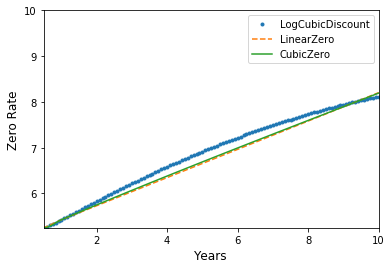

In [16]:
plt.plot(splcd["Maturities"], splcd["Curve"], '.', label="LogCubicDiscount")
plt.plot(splz["Maturities"], splz["Curve"], '--', label="LinearZero")
plt.plot(spcz["Maturities"], spcz["Curve"], label="CubicZero")
plt.xlabel("Years", size=12)
plt.ylabel("Zero Rate", size=12)
plt.xlim(0.5, 10)
plt.ylim([5.25, 10])
plt.legend(loc=0)